# UW-Madison GI Tract Image Segmentation

## Inference

In [3]:
#!/usr/bin/env python

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.options.plotting.backend = "plotly"
from tqdm.notebook import tqdm
tqdm.pandas()
import numpy as np
import os
import re
import cv2
from plotly.offline import init_notebook_mode
from glob import glob

import tensorflow as tf

# Visualization Imports
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm; tqdm.pandas();
import plotly.express as px
import seaborn as sns
from PIL import Image, ImageEnhance
import matplotlib; print(f"\t\t– MATPLOTLIB VERSION: {matplotlib.__version__}");
from matplotlib import animation, rc; rc('animation', html='jshtml')
from matplotlib.colors import LinearSegmentedColormap
import plotly
import PIL
import cv2
import math

# Import Tensorflow and Keras
from tensorflow import keras
import tensorflow as tf
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

from keras.models import load_model


		– MATPLOTLIB VERSION: 3.5.2


In [4]:
%cd 'hpc_train_files'

/Users/viktor/Documents/BA/GIT/HealthyOrganTracker/hpc_train_files


In [5]:
from utility import rle_encode, rle_decode, open_gray16
from config import CFG
from dataloader import DataGenerator
from loss import dice_coef, iou_coef, dice_loss, bce_dice_loss, dice_coef2
from datapreparation import extract_metadata, remove_faulties

## Config ⚙️


In [6]:
BASE_PATH = 'input/uw-madison-gi-tract-image-segmentation/'
TRAIN_DIR =  BASE_PATH +'train'
TRAIN_CSV =  BASE_PATH +'train.csv'
STYE = "multilabel"
DEBUG = True

"""
Backbones available: 
        'efficientnetb0'
        'efficientnetb1'
        'efficientnetb2'
        'efficientnetb3'
        'efficientnetb4'
        'efficientnetb5'
        'efficientnetb6'
        'efficientnetb7'
        'inceptionresnetv2'
        'inceptionv3'
        'resnet50'
        'resnext50'
        'resnext101'
        'seresnext50'
        'seresnext101'
        'densenet121'
        'densenet201'
        """

"\nBackbones available: \n        'efficientnetb0'\n        'efficientnetb1'\n        'efficientnetb2'\n        'efficientnetb3'\n        'efficientnetb4'\n        'efficientnetb5'\n        'efficientnetb6'\n        'efficientnetb7'\n        'inceptionresnetv2'\n        'inceptionv3'\n        'resnet50'\n        'resnext50'\n        'resnext101'\n        'seresnext50'\n        'seresnext101'\n        'densenet121'\n        'densenet201'\n        "

In [7]:
df = pd.read_csv(TRAIN_CSV)
#df = df.sample(n=90, random_state=1)

In [8]:
cfg = CFG(
    backbone            = 'efficientnetb0',
    img_dims            = (256,256,3),
    model               = 'U-Net',
    batch_size          = 16, 
    epochs              = 1, 
    kaggle              = False, 
    use_fold_csv        = True,
    semi3d_data         = False,
    remove_faulty_cases = False,
    use_crop_data       = False)

In [9]:
# Custom color map in matplotlib
def CustomCmap(rgb_color):

    r1,g1,b1 = rgb_color

    cdict = {'red': ((0, r1, r1),
                   (1, r1, r1)),
           'green': ((0, g1, g1),
                    (1, g1, g1)),
           'blue': ((0, b1, b1),
                   (1, b1, b1))}

    cmap = LinearSegmentedColormap('custom_cmap', cdict)
    return cmap


## Load Dataframe with crop infos

In [10]:
df_train = extract_metadata(df, TRAIN_DIR, channels=3, stride=2)
df_train.sample(5)

Frame merged. Shape: (38496, 22)
Remove faulty cases: True
Sucess. Shape: (38208, 22)


id  \
21874  case107_day21_slice_0067   
4761     case24_day0_slice_0010   
24596  case117_day13_slice_0053   
5560    case29_day14_slice_0089   
20000   case89_day21_slice_0001   

                                             large_bowel  \
21874  14283 2 14547 6 14812 8 15077 10 15343 10 1560...   
4761                                                       
24596  21094 4 21368 8 21643 10 21918 12 22194 13 224...   
5560   13668 10 13932 16 13954 11 14196 20 14219 22 1...   
20000                                                      

                                             small_bowel  \
21874  19849 5 20114 7 20380 7 20645 8 20911 9 21176 ...   
4761                                                       
24596  20281 5 20556 8 20574 12 20831 34 21107 40 213...   
5560                                                       
20000                                                      

                                                 stomach  case  day  slice  \
21874  11834 15 12097 19 12361 22 12626 25 12890 30 1...   107   21     67   
4761                                                        24    0     10   
24596                                                      117   13     53   
5560   20351 5 20603 23 20855 42 21117 47 21381 52 21...    29   14     89   
20000                                                       89   21      1   

            case_day                                               path  \
21874  case107_day21  input/uw-madison-gi-tract-image-segmentation/t...   
4761     case24_day0  input/uw-madison-gi-tract-image-segmentation/t...   
24596  case117_day13  input/uw-madison-gi-tract-image-segmentation/t...   
5560    case29_day14  input/uw-madison-gi-tract-image-segmentation/t...   
20000   case89_day21  input/uw-madison-gi-tract-image-segmentation/t...   

       width  ...  pixel_y count  \
21874    266  ...     1.50     3   
4761     266  ...     1.50     0   
24596    276  ...     1.63     2   
5560     266  ...     1.50     2   
20000    276  ...     1.63     0   

                                                  path00  \
21874  input/uw-madison-gi-tract-image-segmentation/t...   
4761   input/uw-madison-gi-tract-image-segmentation/t...   
24596  input/uw-madison-gi-tract-image-segmentation/t...   
5560   input/uw-madison-gi-tract-image-segmentation/t...   
20000  input/uw-madison-gi-tract-image-segmentation/t...   

                                                  path01  \
21874  input/uw-madison-gi-tract-image-segmentation/t...   
4761   input/uw-madison-gi-tract-image-segmentation/t...   
24596  input/uw-madison-gi-tract-image-segmentation/t...   
5560   input/uw-madison-gi-tract-image-segmentation/t...   
20000  input/uw-madison-gi-tract-image-segmentation/t...   

                                                  path02  \
21874  input/uw-madison-gi-tract-image-segmentation/t...   
4761   input/uw-madison-gi-tract-image-segmentation/t...   
24596  input/uw-madison-gi-tract-image-segmentation/t...   
5560   input/uw-madison-gi-tract-image-segmentation/t...   
20000  input/uw-madison-gi-tract-image-segmentation/t...   

                                             image_paths  rs     re  cs   ce  
21874  [input/uw-madison-gi-tract-image-segmentation/...  19  10000   0  266  
4761   [input/uw-madison-gi-tract-image-segmentation/...  46  10000   0  252  
24596  [input/uw-madison-gi-tract-image-segmentation/...  55  10000   0  254  
5560   [input/uw-madison-gi-tract-image-segmentation/...  32  10000   0  262  
20000  [input/uw-madison-gi-tract-image-segmentation/...  53  10000   0  265  

[5 rows x 22 columns]

## Generate Original Masks

In [11]:
IMAGE_SHAPE = SEG_SHAPE = (224,224)

def make_seg_mask(row, output_dir, resize_to, resize=False):
    """"""
    _slice_shape = (row.height, row.width)
    counter  = 0
    
    if not pd.isna(row.large_bowel):
        lb_mask = rle_decode(row.large_bowel, _slice_shape)
    else:
        lb_mask = np.zeros(_slice_shape)
        counter +=1
        
    if not pd.isna(row.small_bowel):
        sb_mask = rle_decode(row.small_bowel, _slice_shape)
    else:
        sb_mask = np.zeros(_slice_shape)
        counter +=1
        
    if not pd.isna(row.stomach):
        st_mask = rle_decode(row.stomach, _slice_shape)
    else:
        st_mask = np.zeros(_slice_shape)
        counter +=1
    
    mask_arr = np.stack([lb_mask, sb_mask, st_mask], axis=-1)
    
    if resize:
        mask_arr = cv2.resize(mask_arr, resize_to, interpolation=cv2.INTER_NEAREST).astype(np.uint8)
            
    mask_path = os.path.join(output_dir, f"{row.id}_mask.png")
    if counter != 3:
        cv2.imwrite(mask_path, mask_arr)
        
    return mask_path

## Plot Masks Helper


In [12]:

def plot_masks_chronologic(imgs, masks, ids, alpha=1):
    
    slices = [i.split("_")[-1] for i in ids]
    
    # Plot
    fig, axs = plt.subplots(2, 5, figsize=(23, 11))
    axs = axs.flatten()
    
    for k, (img, mask) in enumerate(zip(imgs, masks)):

        # Change pixels - when 1 make True, when 0 make NA
        mask = np.ma.masked_where(mask == 0, mask)

        # Split the channels
        mask_largeB = mask[:, :, 0]
        mask_smallB = mask[:, :, 1]
        mask_stomach = mask[:, :, 2]
        
        title = f"{k+1}. Slice {slices[k]}"
        axs[k].set_title(title, fontsize = 16, 
                         color = my_colors[-1], weight='bold')

        axs[k].imshow(img, cmap="gist_gray")
        axs[k].axis("off")
        axs[k].imshow(mask_largeB, interpolation='none', cmap=CMAP1, alpha=alpha)
        axs[k].imshow(mask_smallB, interpolation='none', cmap=CMAP2, alpha=alpha)
        axs[k].imshow(mask_stomach, interpolation='none', cmap=CMAP3, alpha=alpha)
        axs[k].axis("off")
    
    axs[0].legend(legend_colors, labels, loc=2)
    plt.tight_layout()
    plt.show()

In [13]:
DEBUG = False
if DEBUG:
    df_train["multilabel_mask_path"] = df_train.progress_apply(lambda _row: make_seg_mask(_row, outputdir, resize_to=SEG_SHAPE, resize=False), axis=1)
    df_train.to_csv("df_train_with_mask_paths.csv", index=False)
else:
    df_train = pd.read_csv("df_train_with_mask_paths.csv")
    df_train.fillna('', inplace=True)



## Visualiize

In [14]:
mask_colors = [(1.0, 0.7, 0.1), (1.0, 0.5, 1.0), (1.0, 0.22, 0.099)]
legend_colors = [Rectangle((0,0),1,1, color=color) for color in mask_colors]
labels = ["Dickdarm", "Dünndarm", "Magen"]

CMAP1 = CustomCmap(mask_colors[0])
CMAP2 = CustomCmap(mask_colors[1])
CMAP3 = CustomCmap(mask_colors[2])

In [15]:
# Thanks to Darueb Schettler and his notebook: 
# https://www.kaggle.com/code/dschettler8845/uwmgit-deeplabv3-w-se-aspp-tf-e2e-pipeline

def mask_from_segmentation(segmentation, shape):
    '''Returns the mask corresponding to the inputed segmentation.
    segmentation: a list of start points and lengths in this order
    max_shape: the shape to be taken by the mask
    return:: a 2D mask'''

    # Get a list of numbers from the initial segmentation
    segm = np.asarray(segmentation.split(), dtype=int)

    # Get start point and length between points
    start_point = segm[0::2] - 1
    length_point = segm[1::2]

    # Compute the location of each endpoint
    end_point = start_point + length_point

    # Create an empty list mask the size of the original image
    # take onl
    case_mask = np.zeros(shape[0]*shape[1], dtype=np.uint8)

    # Change pixels from 0 to 1 that are within the segmentation
    for start, end in zip(start_point, end_point):
        case_mask[start:end] = 1

    case_mask = case_mask.reshape((shape[0], shape[1]))
    
    return case_mask

In [16]:
# Thanks to Darueb Schettler and his notebook: 
# https://www.kaggle.com/code/dschettler8845/uwmgit-deeplabv3-w-se-aspp-tf-e2e-pipeline

def get_id_mask(ID, train, verbose=False):
    '''Returns a mask for each case ID. If no segmentation was found, the mask will be empty
    - meaning formed by only 0
    ID: the case ID from the train.csv file
    verbose: True if we want any prints
    return: segmentation mask'''

    # ~~~ Get the data ~~~
    # Get the portion of dataframe where we have ONLY the speciffied ID
    ID_data = train[train["id"]==ID].reset_index(drop=True)

    # Split the dataframe into 3 series of observations
    # each for one speciffic class - "large_bowel", "small_bowel", "stomach"
    observations = [ID_data[k] for k in ["large_bowel", "small_bowel", "stomach"]]
    # ~~~ Create the mask ~~~
    # Get the maximum height out of all observations
    # if max == 0 then no class has a segmentation
    # otherwise we keep the length of the mask
    max_height = ID_data['height'].values[0]
    max_width = ID_data['width'].values[0]
    
    # Get shape of the image
    # 3 channels of color/classes
    shape = (max_height, max_width, 3)
    
    if ID_data['count'].values[0] == 0:
        return np.zeros(shape, dtype=np.uint8)

    # Create an empty mask with the shape of the image
    mask = np.zeros(shape, dtype=np.uint8)

    # If there is at least 1 segmentation found in the group of 3 classes
    if max_height != 0:
        for k, location in enumerate(["large_bowel", "small_bowel", "stomach"]):
            observation = ID_data[location].values[0]
            segmentation = observation

            # If a segmentation is found
            # Append a new channel to the mask
            if pd.isnull(segmentation) == False:
                mask[..., k] = mask_from_segmentation(segmentation, shape)

            
    return mask

def get_pred_mask(ID, train):
    ID_data = train[train["id"]==ID].reset_index(drop=True)
    height = ID_data['height'].values[0]
    width = ID_data['width'].values[0]
    shape = (height,width,3)
    masks = np.zeros(shape, dtype=np.uint8)
    
    for k, location in enumerate(["large_bowel_predicted", "small_bowel_predicted", "stomach_predicted"]):
        observation = ID_data[location].values[0]
        if(not isinstance(observation, str)):
            continue
            
        mask = rle_decode(observation, shape=(height,width,1))
        masks[..., k] = np.squeeze(mask)
        
    return masks

In [17]:
# Thanks to Darueb Schettler and his notebook: 
# https://www.kaggle.com/code/dschettler8845/uwmgit-deeplabv3-w-se-aspp-tf-e2e-pipeline

def plot_original_mask(img, mask, alpha=0.4):

    # Change pixels - when 1 make True, when 0 make NA
    mask = np.ma.masked_where(mask == 0, mask)

    # Split the channels
    mask_largeB = mask[:, :, 0]
    mask_smallB = mask[:, :, 1]
    mask_stomach = mask[:, :, 2]


    # Plot the 2 images (Original and with Mask)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

    # Original
    ax1.set_title("Orginalbild")
    ax1.imshow(img)
    ax1.axis("off")

    # With Mask
    ax2.set_title("Segmentiertes Bild")
    ax2.imshow(img)
    ax2.imshow(mask_largeB, interpolation='none', cmap=CMAP1, alpha=alpha)
    ax2.imshow(mask_smallB, interpolation='none', cmap=CMAP2, alpha=alpha)
    ax2.imshow(mask_stomach, interpolation='none', cmap=CMAP3, alpha=alpha)
    ax2.legend(legend_colors, labels)
    ax2.axis("off")
    
#     fig.savefig('foo.png', dpi=500)
    plt.show()
def get_overlay(img, mask, _alpha=0.999, _beta=0.45, _gamma=0):
    
    # Normalize to be between 0-1 (float32)
    img = (img/img.max()).astype(np.float32)

    
    mask_rgb=mask.astype(np.float32)
    
    # overlay
    seg_overlay = cv2.addWeighted(src1=img, alpha=_alpha, 
                                  src2=mask_rgb, beta=_beta, gamma=_gamma)
    return seg_overlay

def get_miss_overlay(gt_mask, pred_mask, _alpha=0.9, _beta=0.25, _gamma=0):
    
    # Make mask RGB and float32
    miss_rgb = np.zeros((*pred_mask.shape[:2],3), dtype=np.float32)
        
    miss_rgb = np.where((gt_mask==pred_mask)&(gt_mask!=0.0), (0.0,0.8,0.0), (0.0,0.0,0.0))
    miss_rgb = np.where((gt_mask!=pred_mask), (0.8,0.0,0.0), miss_rgb)
        
    return miss_rgb

def plot_preds(img, pred_mask, gt_mask):
    gt_overlay = get_overlay(img, gt_mask)
    pred_overlay = get_overlay(img, pred_mask)
    
    plt.figure(figsize=(20,12))
    
    for i, (_desc, _img) in enumerate(zip(["Original", "Vorhersage", "Ground-Truth"], [img, pred_overlay, gt_overlay])):        
        plt.subplot(1,4,i+1)
        plt.imshow(_img)
        plt.title(f"{_desc} Image", fontweight="bold")        
        plt.axis(False)
        
        if i in [1,2]:
            handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
            labels = ["Dickdarm", "Dünndarm", "Magen"]
            plt.legend(handles,labels)
    plt.tight_layout()
    plt.show()



In [18]:
def get_meta_info_from_model_path(file):
    regexBone = 'None' if not re.search("BB_(\w+)_D",file) else re.search("BB_(\w+)_D",file).group(1) 
    regexDim = 'None' if not re.search("DIM_\((\d+),",file) else int(re.search("DIM_\((\d+),",file).group(1) )
    threeDim = 'None' if not re.search("SEMI3D_([aA-zZ]{4,5})_",file) else re.search("SEMI3D_([aA-zZ]{4,5})_",file).group(1) 
    regexCrop = 'None' if not re.search("CROPDATA_([aA-zZ]{4,5})_",file) else re.search("CROPDATA_([aA-zZ]{4,5})_",file).group(1) 
    regexBatch = 'None' if not re.search("BATCH_(\d+)_",file) else int(re.search("BATCH_(\d+)_",file).group(1) )
    regexEpochs = 'None' if not re.search("EPOCHS_(\d+)_",file) else int(re.search("EPOCHS_(\d+)_",file).group(1))
    regexFold = 'None' if not re.search("Fold_(\d).",file) else int(re.search("Fold_(\d).",file).group(1))
    regexFaulties = 'None' if not re.search("FAULTIES_([aA-zZ]{4,5})_",file) else re.search("FAULTIES_([aA-zZ]{4,5})_",file).group(1)

    return regexBone, regexDim, threeDim, regexCrop, regexBatch, regexEpochs, regexFold, regexFaulties

In [19]:
for result in glob(os.path.join("../tensorboard_logs/efb2", "**", "*val_results.csv"), recursive=True):
    print(result)

../tensorboard_logs/efb2/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_False_CROPDATA_True_FAULTIES_True_BATCH_16_EPOCHS_50_FOLD_3.h5_29082022-2034_FOLD_3/model.h5_val_results.csv
../tensorboard_logs/efb2/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_True_CROPDATA_True_FAULTIES_True_BATCH_16_EPOCHS_50_FOLD_3.h5_29082022-2034_FOLD_3/model.h5_val_results.csv
../tensorboard_logs/efb2/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_True_CROPDATA_False_FAULTIES_False_BATCH_16_EPOCHS_50_FOLD_3.h5_29082022-2034_FOLD_3/model.h5_val_results.csv
../tensorboard_logs/efb2/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_False_CROPDATA_False_FAULTIES_False_BATCH_16_EPOCHS_50_FOLD_3.h5_29082022-2033_FOLD_3/model.h5_val_results.csv
../tensorboard_logs/efb2/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_False_CROPDATA_False_FAULTIES_True_BATCH_16_EPOCHS_50_FOLD_3.h5_29082022-2033_FOLD_3/model.h5_val_results.csv
../tensorboard_logs/efb2/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_True_CROPDATA_

In [20]:
def evaluate_models(path):
    eval_ = pd.DataFrame(columns=['Encoder','Größe', '2.5D', 'Crop' , 'Bereinigt', 'Batch Size', 'Epochen', 'Dickdarm', 'Dünndarm', 'Magen', 'Schnitt'])
    for result in glob(os.path.join(path, "**", "*val_results.csv"), recursive=True):
        print(result)
        df_val = pd.read_csv(result)

        df_val['large_bowel_dice_coef'] = df_val['large_bowel_dice_coef']
        df_val['small_bowel_dice_coef'] = df_val['small_bowel_dice_coef']
        df_val['stomach_dice_coef'] = df_val['stomach_dice_coef']

        regexBone, regexDim, threeDim, regexCrop, regexBatch, regexEpochs, regexFold, regexFaulties = get_meta_info_from_model_path(result)

        mean_stomach_score = df_val['stomach_dice_coef'].mean()
        mean_sb_score = df_val['small_bowel_dice_coef'].mean()
        mean_lb_score = df_val['large_bowel_dice_coef'].mean()
        
        mean_total = (mean_stomach_score + mean_sb_score + mean_lb_score) / 3

        eval_ = eval_.append({'Encoder':regexBone, 'Größe':regexDim, '2.5D':threeDim, 'Crop':regexCrop,'Bereinigt':regexFaulties ,'Batch Size':regexBatch, 'Epochen':regexEpochs, 'Dickdarm':mean_lb_score, 'Dünndarm':mean_sb_score, 'Magen':mean_stomach_score, 'Schnitt':mean_total}, ignore_index=True)

    return eval_.sort_values(by=['Schnitt'], ascending=False)

def print_history_latex(history_df):

    print(history_df.to_latex(index=False , float_format=lambda x: '{:.4f}'.format(x)))

# Evaluation

In [21]:
ev = evaluate_models('../tensorboard_logs/efb2')

../tensorboard_logs/efb2/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_False_CROPDATA_True_FAULTIES_True_BATCH_16_EPOCHS_50_FOLD_3.h5_29082022-2034_FOLD_3/model.h5_val_results.csv
../tensorboard_logs/efb2/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_True_CROPDATA_True_FAULTIES_True_BATCH_16_EPOCHS_50_FOLD_3.h5_29082022-2034_FOLD_3/model.h5_val_results.csv
../tensorboard_logs/efb2/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_True_CROPDATA_False_FAULTIES_False_BATCH_16_EPOCHS_50_FOLD_3.h5_29082022-2034_FOLD_3/model.h5_val_results.csv
../tensorboard_logs/efb2/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_False_CROPDATA_False_FAULTIES_False_BATCH_16_EPOCHS_50_FOLD_3.h5_29082022-2033_FOLD_3/model.h5_val_results.csv
../tensorboard_logs/efb2/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_False_CROPDATA_False_FAULTIES_True_BATCH_16_EPOCHS_50_FOLD_3.h5_29082022-2033_FOLD_3/model.h5_val_results.csv
../tensorboard_logs/efb2/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_True_CROPDATA_

In [22]:
ev

Encoder Größe   2.5D   Crop Bereinigt Batch Size Epochen  Dickdarm  \
2  efficientnetb2   256   True  False     False         16      50  0.880739   
5  efficientnetb2   256   True  False      True         16      50  0.879014   
4  efficientnetb2   256  False  False      True         16      50  0.865164   
1  efficientnetb2   256   True   True      True         16      50  0.854681   
6  efficientnetb2   256   True   True     False         16      50  0.849214   
0  efficientnetb2   256  False   True      True         16      50  0.849516   
7  efficientnetb2   256  False   True     False         16      50  0.841305   
3  efficientnetb2   256  False  False     False         16      50  0.812559   

   Dünndarm     Magen   Schnitt  
2  0.837024  0.899514  0.872426  
5  0.839723  0.892337  0.870358  
4  0.828431  0.884945  0.859513  
1  0.802164  0.869618  0.842154  
6  0.791725  0.877544  0.839494  
0  0.791646  0.863306  0.834823  
7  0.787231  0.855043   0.82786  
3  0.748727  0.833459  0.798249

In [23]:
def load_evaluation(path):
    model_fff = pd.read_csv(path)
    model_fff['dice_mean'] = model_fff[['large_bowel_dice_coef','small_bowel_dice_coef','stomach_dice_coef']].mean(axis=1)
    return model_fff

In [24]:
def plot_results_w_every_model(path, ID, df_train):
    for result in glob(os.path.join(path, "**", "*val_results.csv"), recursive=True):
        df_val = load_evaluation(result)

        to_plot = df_val[df_val['id'] == ID]
        
        print(to_plot['dice_mean'].values[0])

        img_path = df_val[df_val['id'] == ID]['path'].values[0]

        img = open_gray16(img_path, normalize=True, to_rgb=True)
        img = ((img-img.min())/(img.max()-img.min())).astype(np.float32)

        mask = get_id_mask(ID,df_train, verbose=False)

        pred = get_pred_mask(ID, df_val)

        print(result)
        print(pred.shape)
        #plot_original_mask(img, mask, alpha=0.6)
        plot_preds(img, pred, mask)

In [25]:
path = "../tensorboard_logs/efb2/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_False_CROPDATA_True_FAULTIES_True_BATCH_16_EPOCHS_50_FOLD_3.h5_29082022-2034_FOLD_3/model.h5_val_results.csv"
df_val = load_evaluation(path)
df = df_val[df_val['count'] == 3]
df

index  Unnamed: 0                        id  \
78     3102        3102   case18_day19_slice_0079   
79     3103        3103   case18_day19_slice_0080   
80     3104        3104   case18_day19_slice_0081   
81     3105        3105   case18_day19_slice_0082   
207    3231        3231   case18_day21_slice_0064   
...     ...         ...                       ...   
7913  38169       38169  case156_day11_slice_0106   
7914  38170       38170  case156_day11_slice_0107   
7915  38171       38171  case156_day11_slice_0108   
7916  38172       38172  case156_day11_slice_0109   
7917  38173       38173  case156_day11_slice_0110   

                                            large_bowel  \
78    34354 13 34712 26 34742 7 35070 42 35428 55 35...   
79    34000 3 34357 10 34715 14 35071 19 35428 22 35...   
80    34356 10 34714 14 35072 17 35429 21 35786 24 3...   
81    34357 9 34714 14 35072 17 35429 20 35786 24 35...   
207   44525 6 44883 10 45242 12 45601 14 45961 14 46...   
...                                                 ...   
7913  21459 8 21723 12 21988 14 22253 16 22519 17 22...   
7914  21459 8 21724 11 21989 13 22254 15 22519 16 22...   
7915  21460 6 21724 10 21989 12 22255 13 22520 14 22...   
7916  21458 8 21723 10 21988 12 22253 14 22519 14 22...   
7917  21191 6 21455 10 21720 12 21986 13 22251 15 22...   

                                            small_bowel  \
78    46950 4 47309 5 47668 7 48028 7 48387 9 48747 ...   
79    34735 5 35093 8 35452 9 35811 11 36171 11 3653...   
80    34734 6 35093 8 35452 10 35812 10 36172 10 365...   
81    34734 5 35093 8 35452 9 35812 10 36172 10 3653...   
207   26393 5 26745 16 27104 18 27463 20 27823 20 28...   
...                                                 ...   
7913  27052 8 27317 11 27582 13 27847 16 28112 18 28...   
7914  27054 6 27318 10 27583 13 27848 16 28113 19 28...   
7915  27585 11 27850 14 28115 17 28380 19 28646 21 2...   
7916  27587 8 27851 12 28116 15 28381 18 28647 19 28...   
7917  27587 7 27851 11 28116 14 28381 17 28647 19 28...   

                                                stomach  case  day  slice  \
78    45524 2 45876 13 46234 16 46593 18 46952 20 47...    18   19     79   
79    45878 8 46235 13 46594 15 46953 17 47312 18 47...    18   19     80   
80    46238 8 46595 13 46954 14 47313 16 47672 17 48...    18   19     81   
81    46597 5 46955 9 47313 12 47672 14 48032 15 483...    18   19     82   
207   29720 13 30078 19 30436 23 30795 25 31154 27 3...    18   21     64   
...                                                 ...   ...  ...    ...   
7913  18758 13 19021 19 19285 23 19550 26 19815 28 2...   156   11    106   
7914  18760 9 19022 17 19287 20 19551 23 19816 25 20...   156   11    107   
7915  19024 12 19288 17 19553 19 19818 21 20083 23 2...   156   11    108   
7916  19290 12 19554 16 19819 18 20084 20 20350 21 2...   156   11    109   
7917  19559 7 19823 11 20088 14 20354 14 20619 16 20...   156   11    110   

                                                   path  ...     ce  \
78    input/uw-madison-gi-tract-image-segmentation/t...  ...  295.0   
79    input/uw-madison-gi-tract-image-segmentation/t...  ...  295.0   
80    input/uw-madison-gi-tract-image-segmentation/t...  ...  295.0   
81    input/uw-madison-gi-tract-image-segmentation/t...  ...  295.0   
207   input/uw-madison-gi-tract-image-segmentation/t...  ...  359.0   
...                                                 ...  ...    ...   
7913  input/uw-madison-gi-tract-image-segmentation/t...  ...  266.0   
7914  input/uw-madison-gi-tract-image-segmentation/t...  ...  266.0   
7915  input/uw-madison-gi-tract-image-segmentation/t...  ...  266.0   
7916  input/uw-madison-gi-tract-image-segmentation/t...  ...  266.0   
7917  input/uw-madison-gi-tract-image-segmentation/t...  ...  266.0   

                                   multilabel_mask_path  fold  \
78    input/uw-madison-gi-tract-image-segmentation/m...     3   
79    input/uw-madison-gi-tract-image-segme

In [36]:
def get_outliers(path, best=False):
    worst = pd.DataFrame(columns=['Path','ID'])

    for result in glob(os.path.join(path, "**", "*val_results.csv"), recursive=True):
        print(result)
        df_val = load_evaluation(result)
        
        if best:
            df_val =  df_val[df_val['count'] >= 2]
            df_val =  df_val[df_val['dice_mean'] < 1].nlargest(10, 'dice_mean')
        else:
            df_val =  df_val[df_val['dice_mean'] < 1].nsmallest(10, 'dice_mean')
        for i in range(len(df)):
            ID = df['id'].values[i]

            worst = worst.append({'Path': result, 'ID': ID}, ignore_index=True)
            
    return worst

In [37]:
worst = get_outliers("../tensorboard_logs/efb2", best=True)

../tensorboard_logs/efb2/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_False_CROPDATA_True_FAULTIES_True_BATCH_16_EPOCHS_50_FOLD_3.h5_29082022-2034_FOLD_3/model.h5_val_results.csv
../tensorboard_logs/efb2/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_True_CROPDATA_True_FAULTIES_True_BATCH_16_EPOCHS_50_FOLD_3.h5_29082022-2034_FOLD_3/model.h5_val_results.csv
../tensorboard_logs/efb2/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_True_CROPDATA_False_FAULTIES_False_BATCH_16_EPOCHS_50_FOLD_3.h5_29082022-2034_FOLD_3/model.h5_val_results.csv
../tensorboard_logs/efb2/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_False_CROPDATA_False_FAULTIES_False_BATCH_16_EPOCHS_50_FOLD_3.h5_29082022-2033_FOLD_3/model.h5_val_results.csv
../tensorboard_logs/efb2/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_False_CROPDATA_False_FAULTIES_True_BATCH_16_EPOCHS_50_FOLD_3.h5_29082022-2033_FOLD_3/model.h5_val_results.csv
../tensorboard_logs/efb2/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_True_CROPDATA_

In [40]:
worst['ID'].value_counts()

case18_day19_slice_0079     8
case138_day12_slice_0097    8
case139_day0_slice_0089     8
case139_day0_slice_0090     8
case139_day0_slice_0091     8
                           ..
case41_day32_slice_0105     8
case41_day32_slice_0106     8
case41_day32_slice_0107     8
case41_day32_slice_0108     8
case156_day11_slice_0110    8
Name: ID, Length: 581, dtype: int64

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.9046408335367838
../tensorboard_logs/efb2/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_False_CROPDATA_True_FAULTIES_True_BATCH_16_EPOCHS_50_FOLD_3.h5_29082022-2034_FOLD_3/model.h5_val_results.csv
(266, 266, 3)


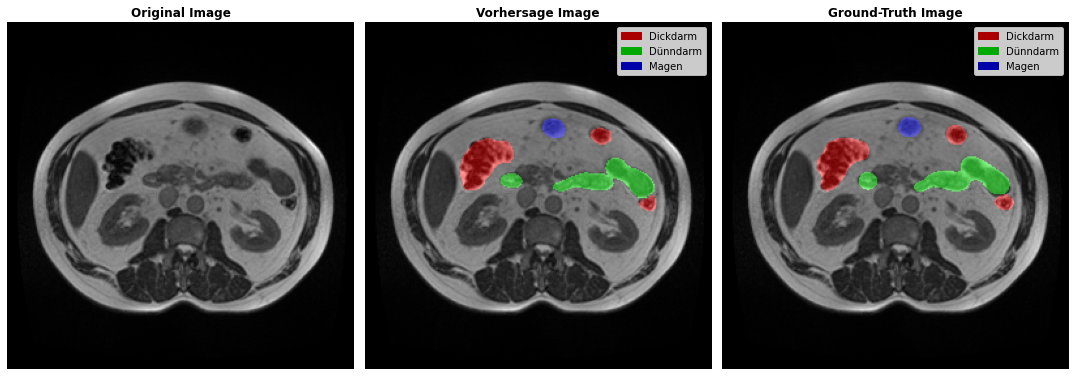

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.9133760333061218
../tensorboard_logs/efb2/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_True_CROPDATA_True_FAULTIES_True_BATCH_16_EPOCHS_50_FOLD_3.h5_29082022-2034_FOLD_3/model.h5_val_results.csv
(266, 266, 3)


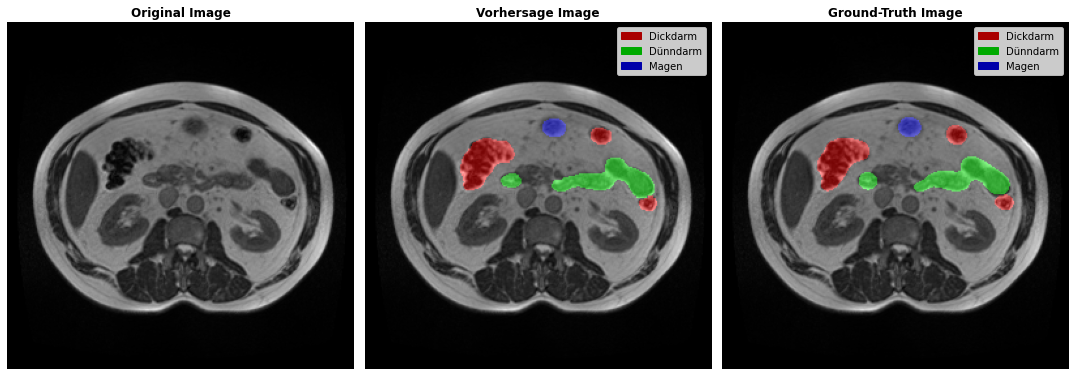

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.8365073204040527
../tensorboard_logs/efb2/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_True_CROPDATA_False_FAULTIES_False_BATCH_16_EPOCHS_50_FOLD_3.h5_29082022-2034_FOLD_3/model.h5_val_results.csv
(266, 266, 3)


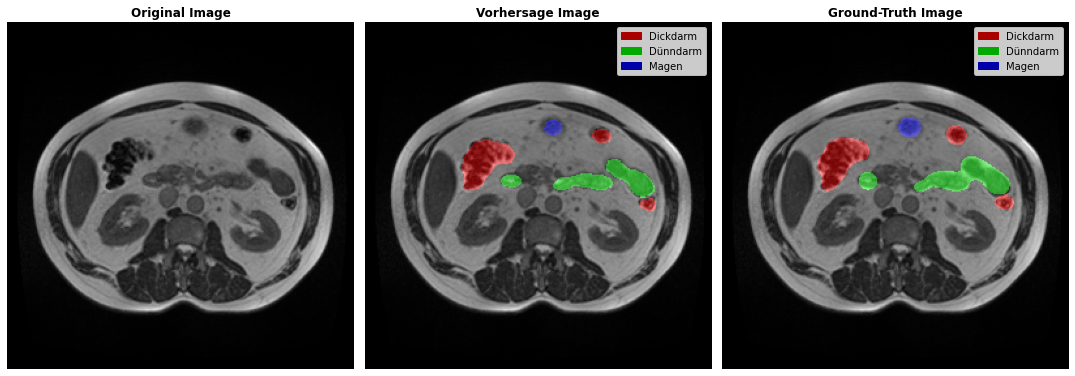

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.8097821871439616
../tensorboard_logs/efb2/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_False_CROPDATA_False_FAULTIES_False_BATCH_16_EPOCHS_50_FOLD_3.h5_29082022-2033_FOLD_3/model.h5_val_results.csv
(266, 266, 3)


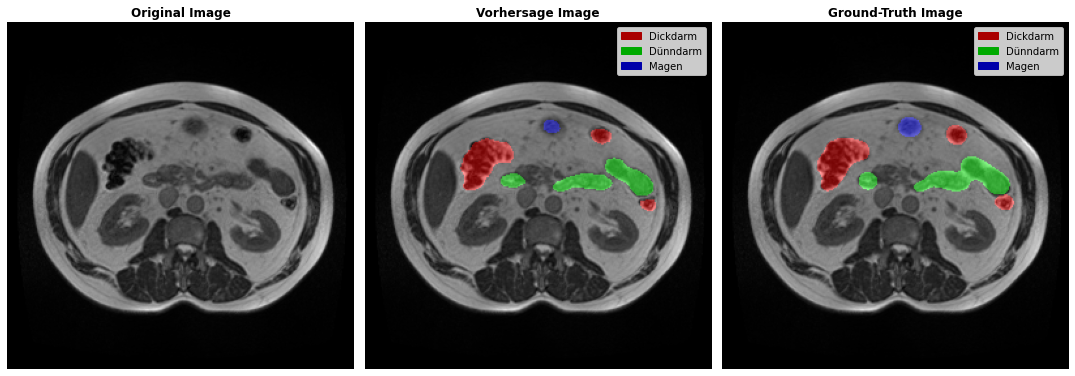

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.9202958544095358
../tensorboard_logs/efb2/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_False_CROPDATA_False_FAULTIES_True_BATCH_16_EPOCHS_50_FOLD_3.h5_29082022-2033_FOLD_3/model.h5_val_results.csv
(266, 266, 3)


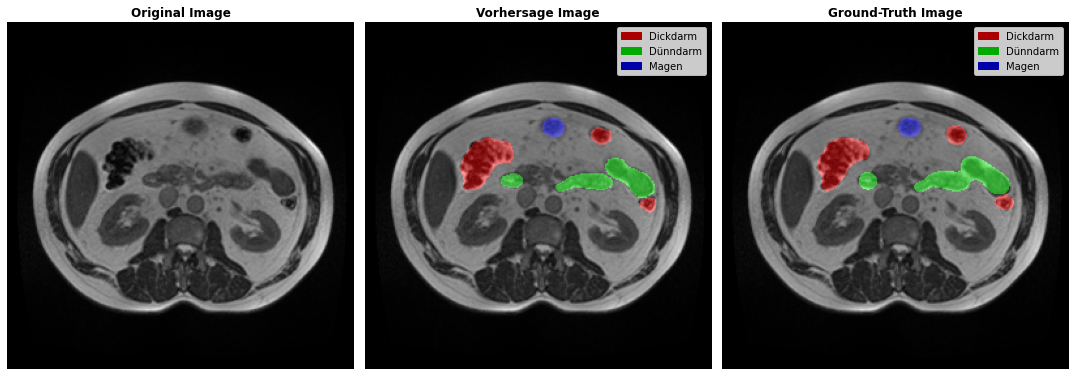

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.9279665350914001
../tensorboard_logs/efb2/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_True_CROPDATA_False_FAULTIES_True_BATCH_16_EPOCHS_50_FOLD_3.h5_29082022-2034_FOLD_3/model.h5_val_results.csv
(266, 266, 3)


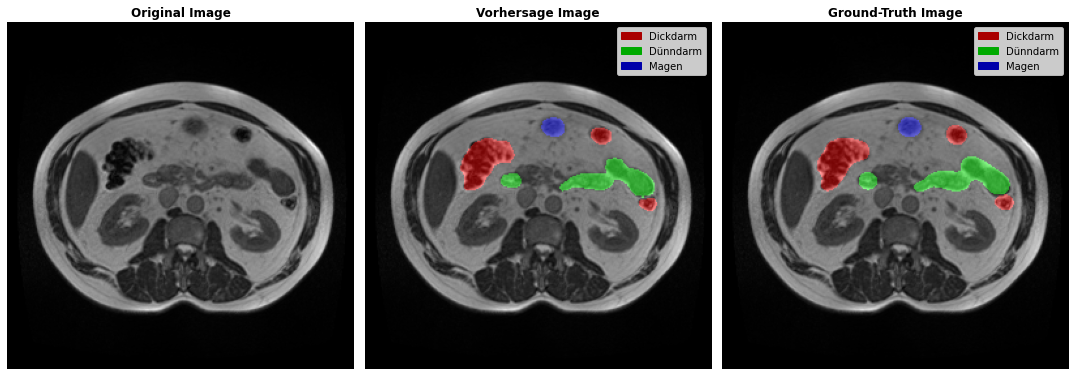

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.8126333157221476
../tensorboard_logs/efb2/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_True_CROPDATA_True_FAULTIES_False_BATCH_16_EPOCHS_50_FOLD_3.h5_29082022-2034_FOLD_3/model.h5_val_results.csv
(266, 266, 3)


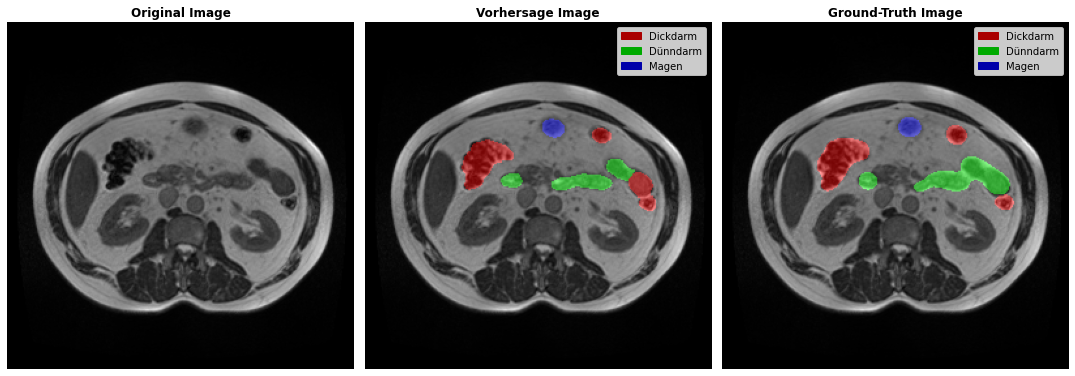

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.887597938378652
../tensorboard_logs/efb2/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_False_CROPDATA_True_FAULTIES_False_BATCH_16_EPOCHS_50_FOLD_3.h5_29082022-2033_FOLD_3/model.h5_val_results.csv
(266, 266, 3)


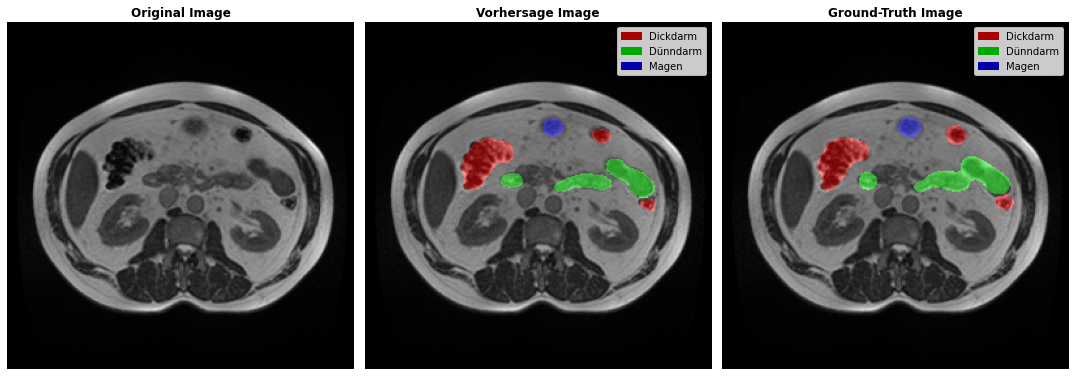

In [42]:
plot_results_w_every_model("../tensorboard_logs/efb2", "case156_day11_slice_0110", df_train)

In [56]:
diff = model_ttf['dice_mean'] - model_fff['dice_mean']
diff.dropna().nsmallest(10)

1610   -0.886880
1611   -0.818762
4816   -0.785523
2030   -0.620440
4032   -0.519129
827    -0.458322
4017   -0.457777
6857   -0.453645
448    -0.447113
4234   -0.445949
Name: dice_mean, dtype: float64

In [175]:
mask = get_id_mask("case156_day11_slice_0107", df_train)

In [176]:
mask

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [59]:
model_fff.loc[1610]

index                                                                 8458
Unnamed: 0                                                            8458
id                                                 case36_day16_slice_0123
large_bowel              23490 9 23754 13 24018 15 24283 17 24548 18 24...
small_bowel              21145 11 21410 15 21665 28 21703 3 21925 36 21...
stomach                                                                NaN
case                                                                    36
day                                                                     16
slice                                                                  123
path                     input/uw-madison-gi-tract-image-segmentation/t...
width                                                                  266
height                                                                 266
pixel_x                                                                1.5
pixel_y                  

case88_day36_slice_0122
0.00034730584593485
(310, 360, 3)


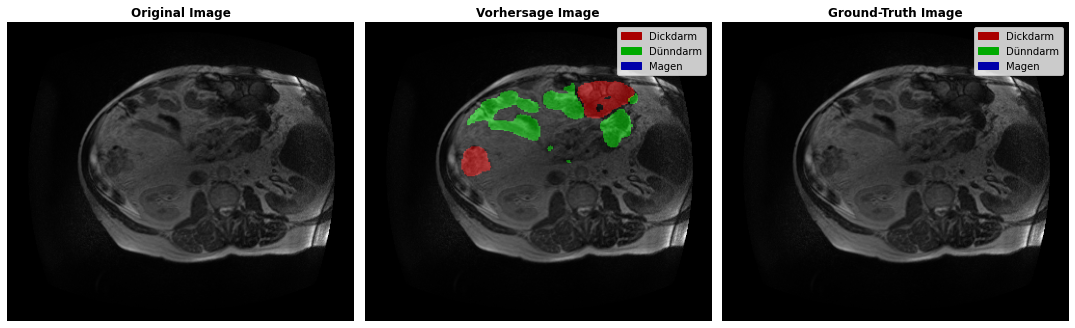

case88_day36_slice_0121
0.00038830627454439996
(310, 360, 3)


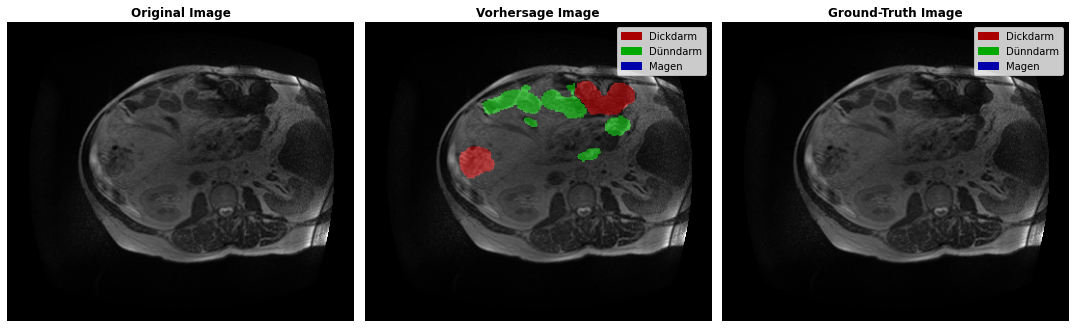

case88_day0_slice_0121
0.00039664153155165
(310, 360, 3)


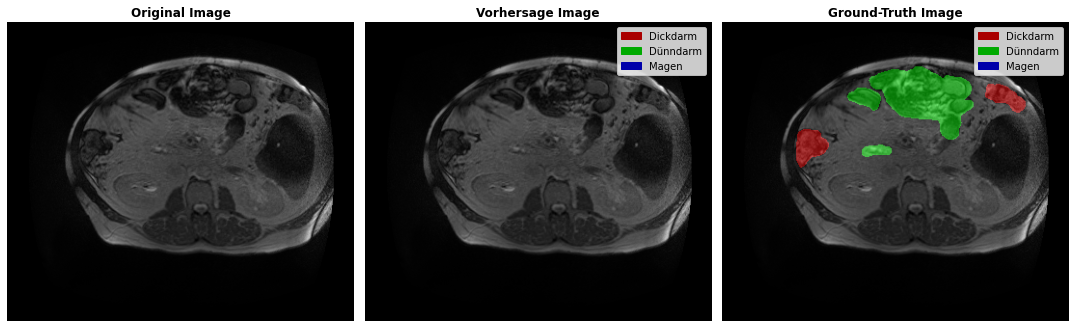

case88_day0_slice_0122
0.00040339653787665
(310, 360, 3)


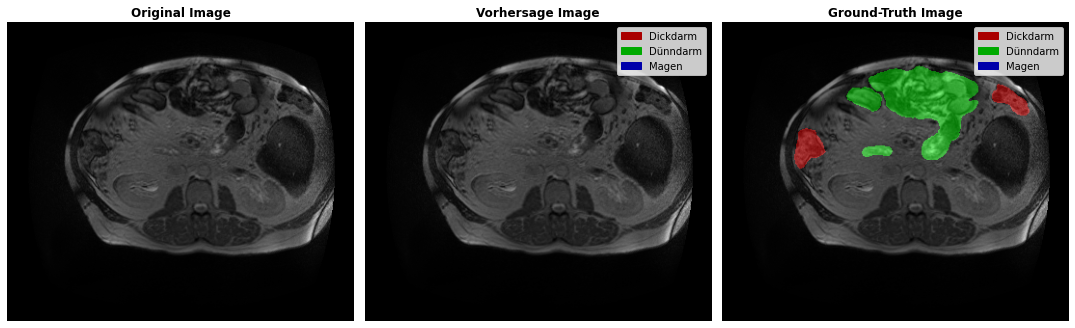

case40_day17_slice_0122
0.00044451512803785
(266, 266, 3)


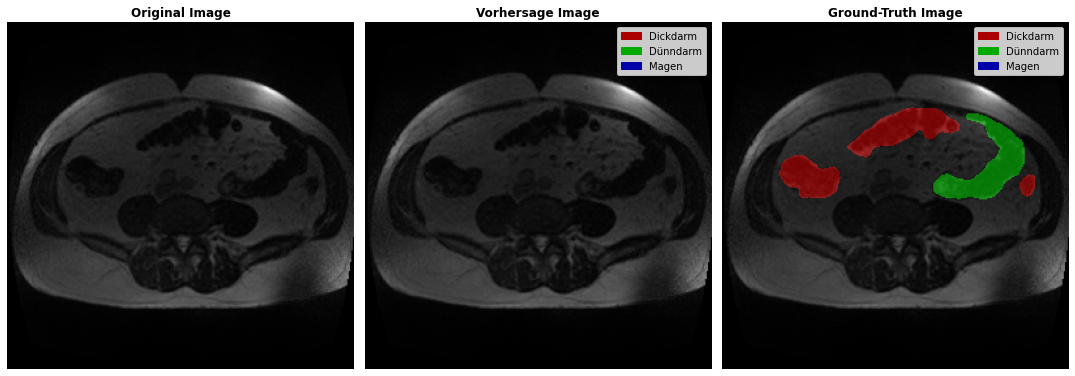

case40_day17_slice_0123
0.00045005779247724996
(266, 266, 3)


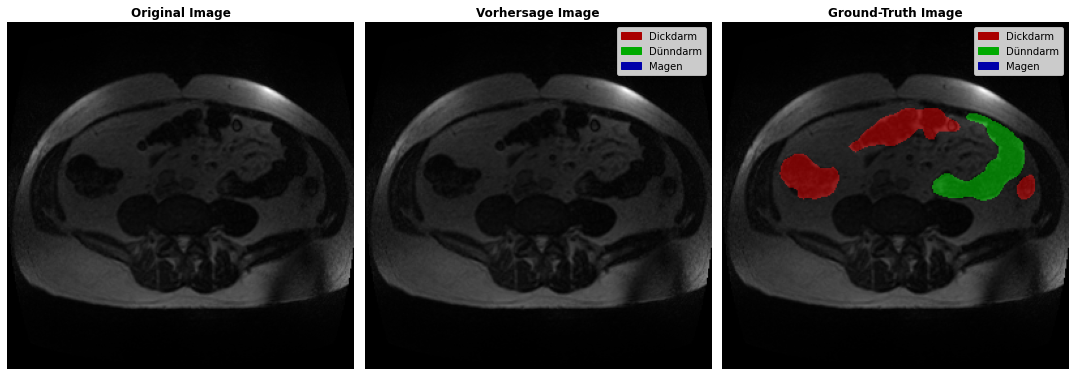

case40_day17_slice_0121
0.00045136132393955005
(266, 266, 3)


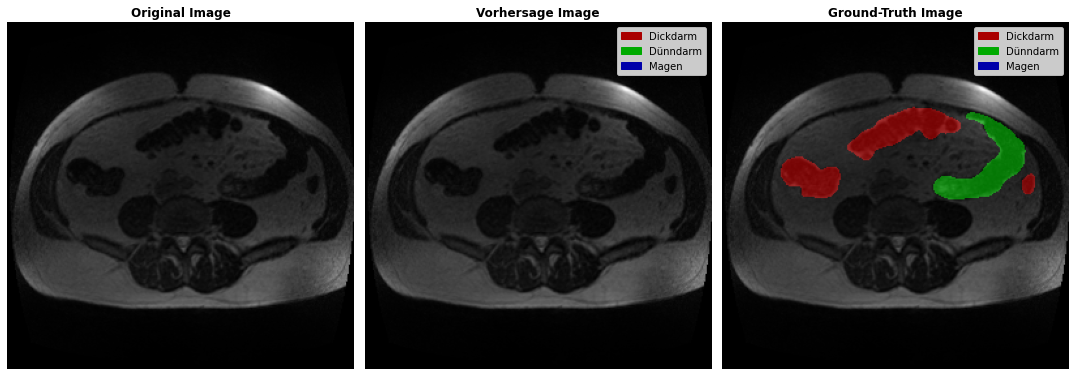

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


case49_day13_slice_0109
0.00045463854621625
(310, 360, 3)


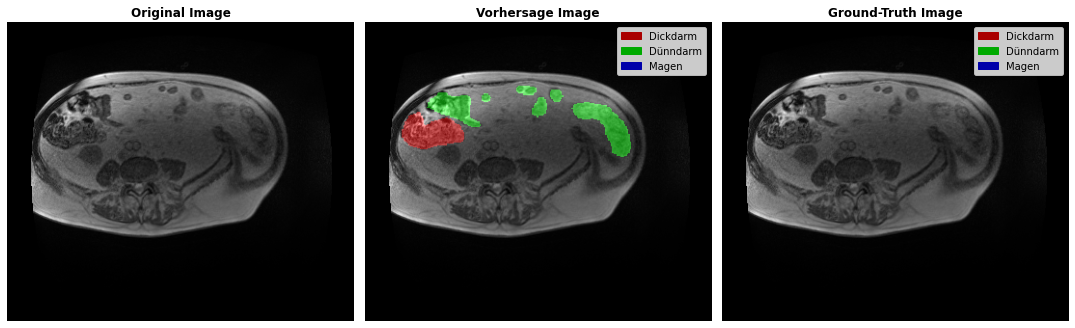

case40_day17_slice_0120
0.00046538434980895004
(266, 266, 3)


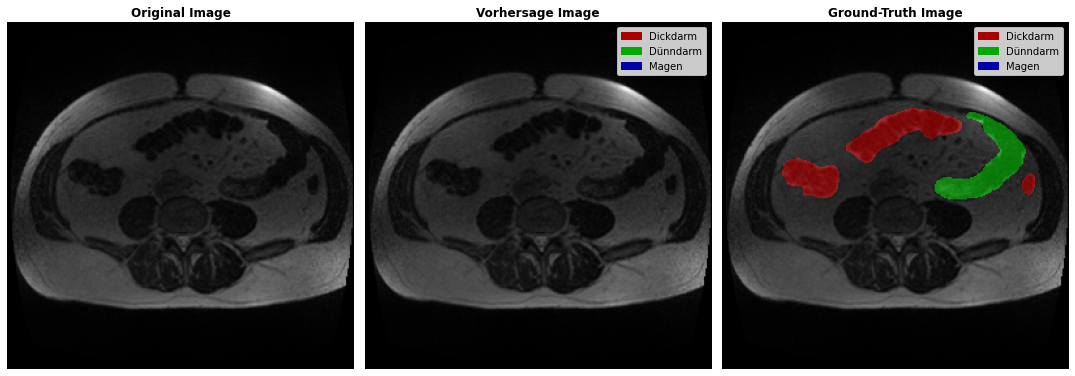

case40_day0_slice_0120
0.00049754540668795
(266, 266, 3)


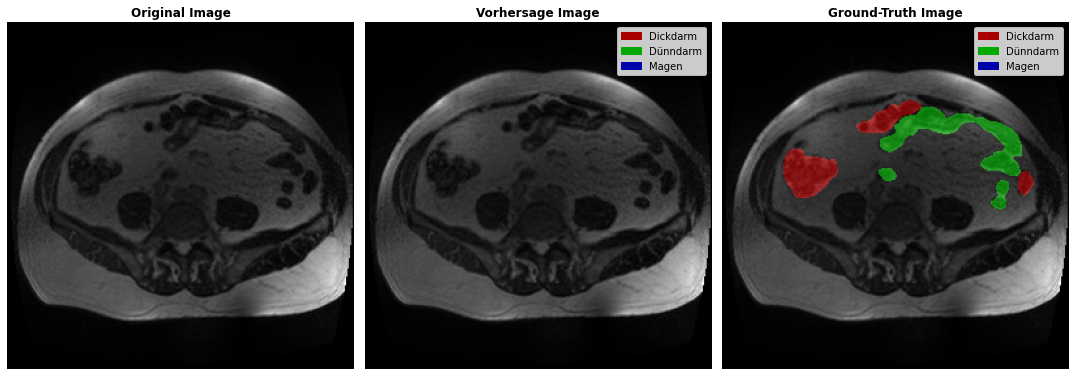

In [349]:
smallest =  df_val[df_val['dice_mean'] < 1].nsmallest(10, 'dice_mean')
for i in range(len(smallest)):
    ID = smallest['id'].values[i]
    
    print(ID)
    print(df_val[df_val['id'] == ID]['dice_mean'].values[0])
    
    img_path = df_val[df_val['id'] == ID]['path'].values[0]
    
    img = open_gray16(img_path, normalize=True, to_rgb=True)
    img = ((img-img.min())/(img.max()-img.min())).astype(np.float32)
    
    mask = get_id_mask(ID,df_train, verbose=False)
        
    pred = get_pred_mask(ID, df_val)
    
    print(pred.shape)
    #plot_original_mask(img, mask, alpha=0.6)
    plot_preds(img, pred, mask)

case88_day36_slice_0122
0.00034730584593485
(310, 360, 3)


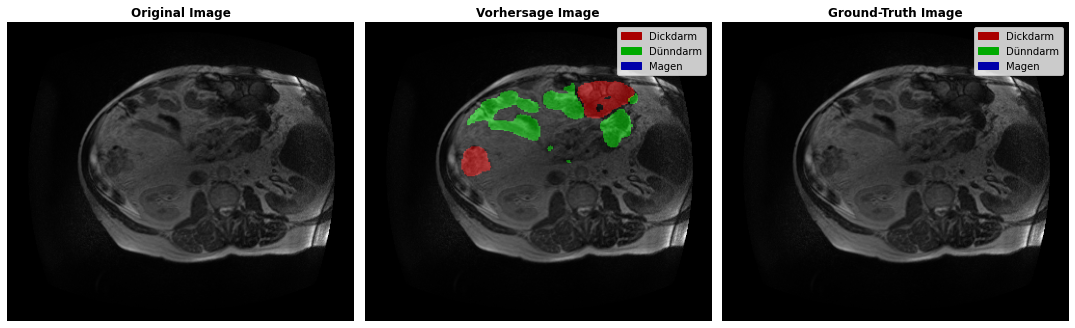

case88_day36_slice_0121
0.00038830627454439996
(310, 360, 3)


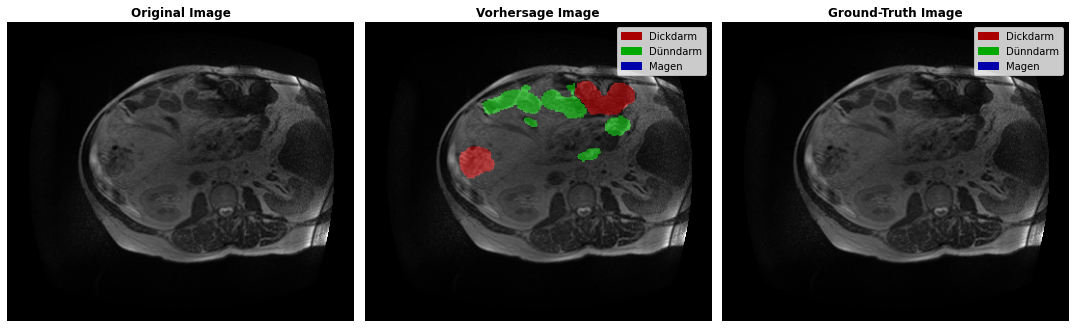

case88_day0_slice_0121
0.00039664153155165
(310, 360, 3)


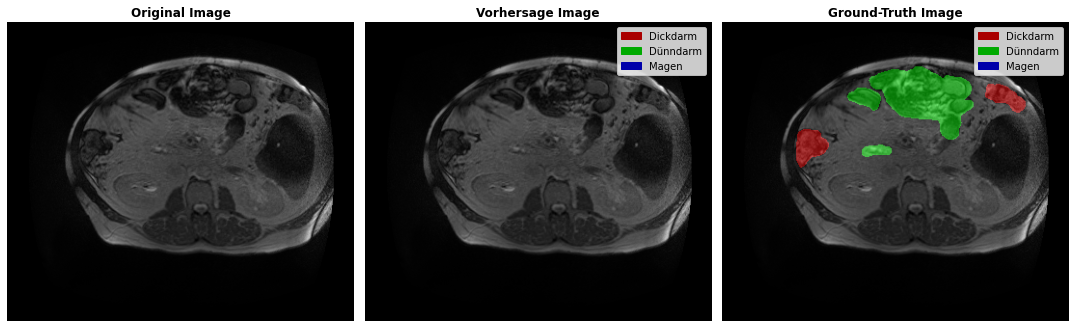

case88_day0_slice_0122
0.00040339653787665
(310, 360, 3)


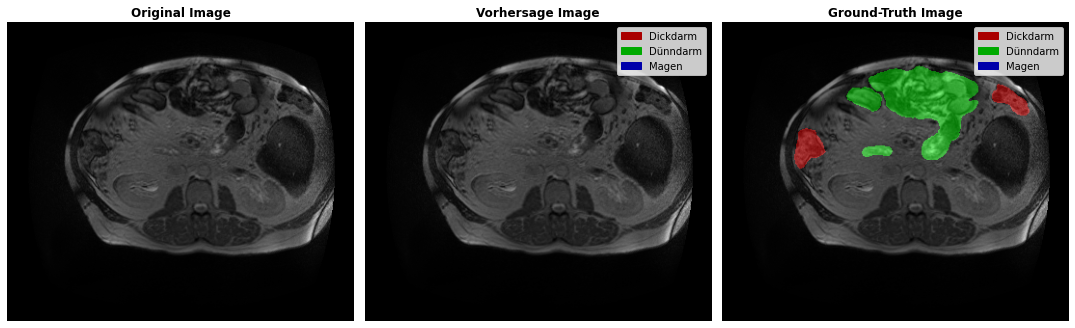

case40_day17_slice_0122
0.00044451512803785
(266, 266, 3)


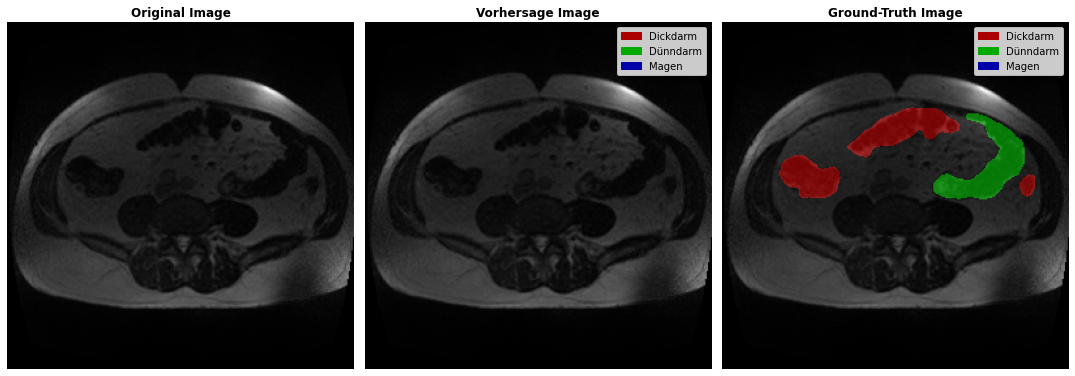

case40_day17_slice_0123
0.00045005779247724996
(266, 266, 3)


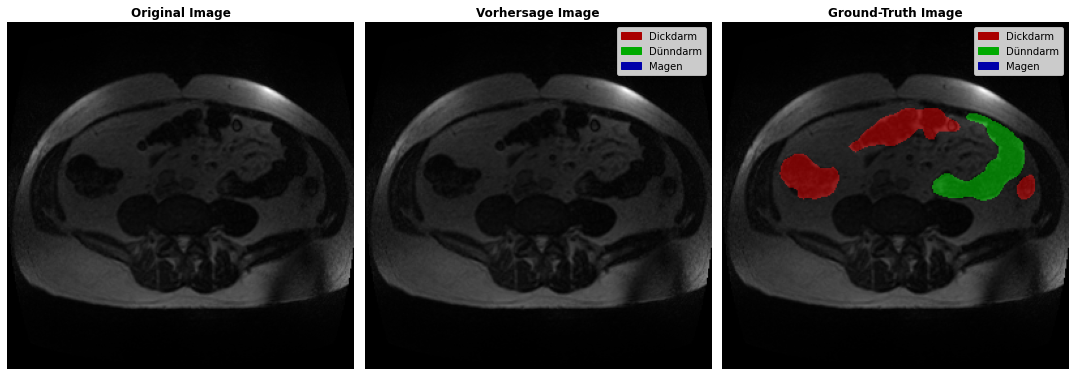

case40_day17_slice_0121
0.00045136132393955005
(266, 266, 3)


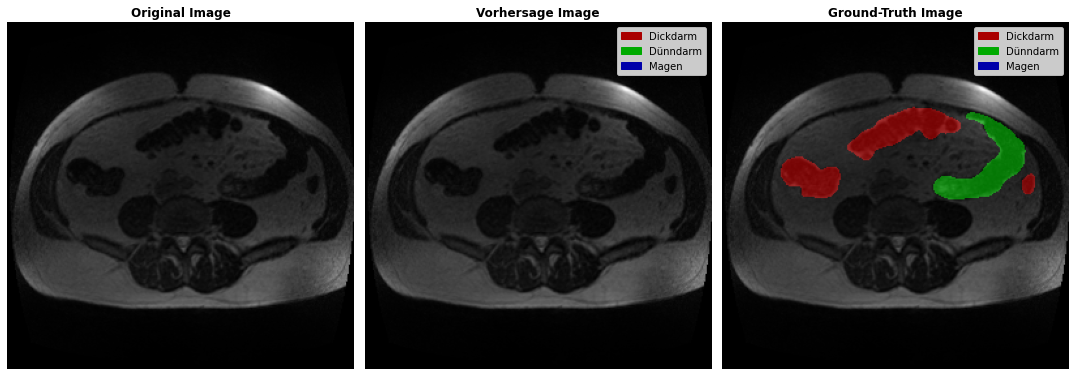

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


case49_day13_slice_0109
0.00045463854621625
(310, 360, 3)


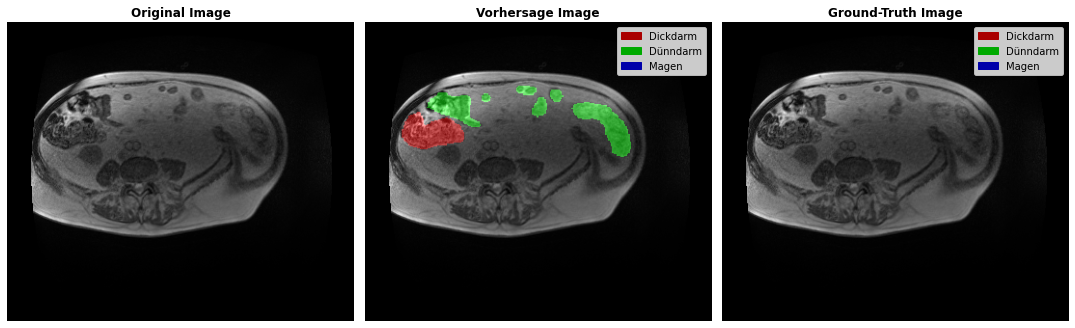

case40_day17_slice_0120
0.00046538434980895004
(266, 266, 3)


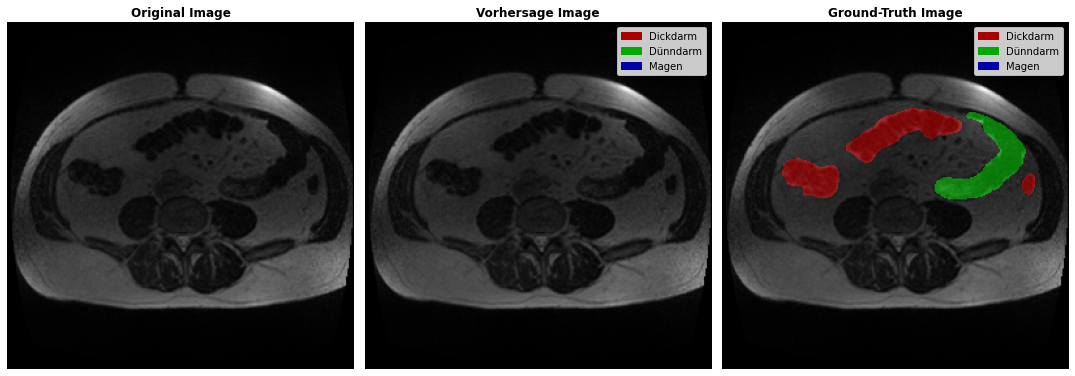

case40_day0_slice_0120
0.00049754540668795
(266, 266, 3)


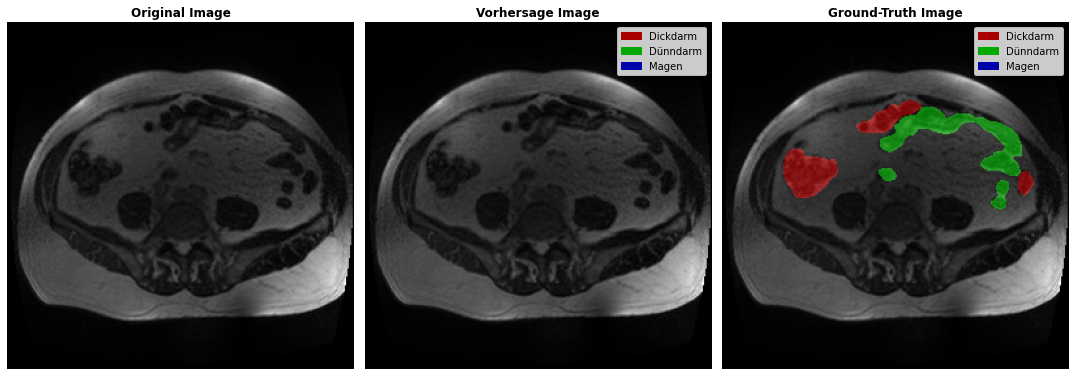

In [353]:
data = pd.read_csv("../tensorboard_logs/efb2/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_True_CROPDATA_True_FAULTIES_True_BATCH_16_EPOCHS_50_FOLD_3.h5_23082022-2114_FOLD_3/model.h5_val_results.csv")
df_val['dice_mean'] = df_val[['large_bowel_dice_coef','small_bowel_dice_coef','stomach_dice_coef']].mean(axis=1)

smallest =  df_val[df_val['dice_mean'] < 1].nsmallest(10, 'dice_mean')
for i in range(len(smallest)):
    ID = smallest['id'].values[i]
    
    print(ID)
    print(df_val[df_val['id'] == ID]['dice_mean'].values[0])
    
    img_path = df_val[df_val['id'] == ID]['path'].values[0]
    
    img = open_gray16(img_path, normalize=True, to_rgb=True)
    img = ((img-img.min())/(img.max()-img.min())).astype(np.float32)
    
    mask = get_id_mask(ID,df_train, verbose=False)
        
    pred = get_pred_mask(ID, df_val)
    
    print(pred.shape)
    #plot_original_mask(img, mask, alpha=0.6)
    plot_preds(img, pred, mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


case123_day20_slice_0073
(266, 266, 3)


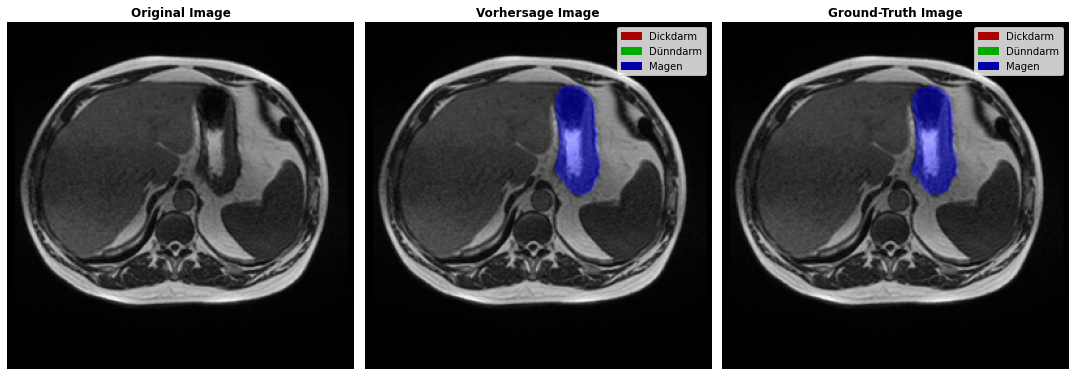

case36_day10_slice_0057
(266, 266, 3)


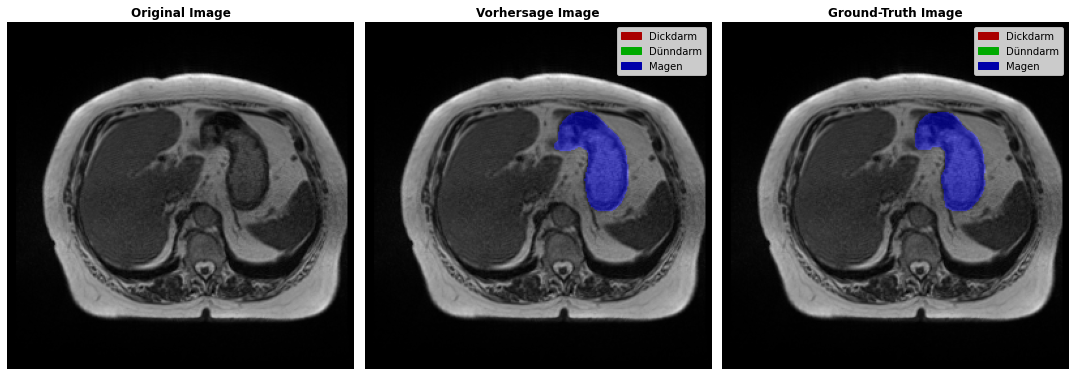

case36_day10_slice_0059
(266, 266, 3)


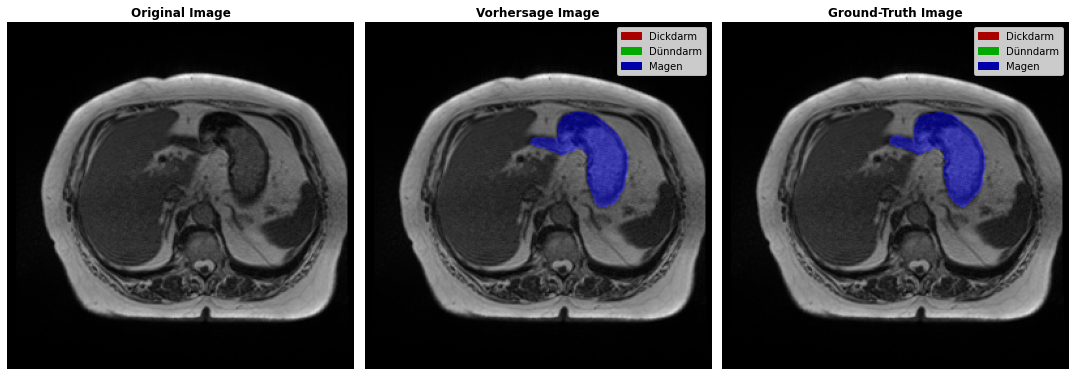

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


case123_day20_slice_0074
(266, 266, 3)


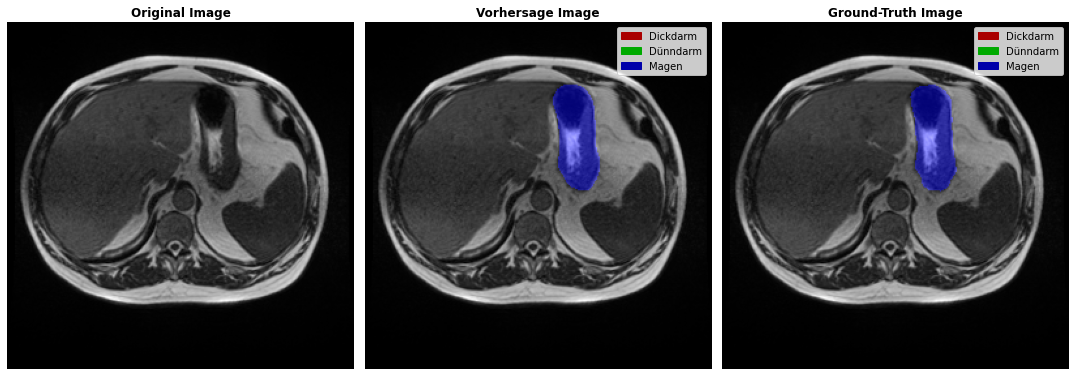

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


case123_day22_slice_0074
(266, 266, 3)


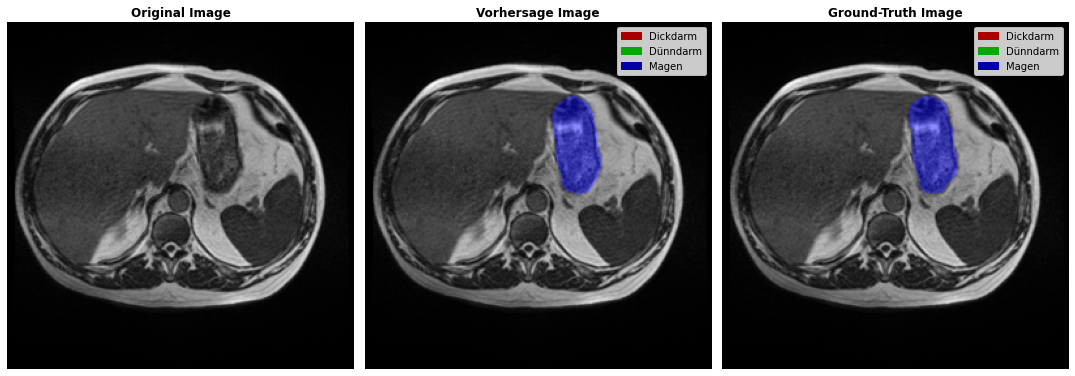

In [186]:
biggest =  df_val[df_val['dice_mean'] < 1].nlargest(5, 'dice_mean')

for i in range(len(biggest)):
    ID = biggest['id'].values[i]
    print(ID)
    
    img_path = df_val[df_val['id'] == ID]['path'].values[0]
    mask_path = df_val[df_val['id'] == ID]['multilabel_mask_path'].values[0]
    
    img = open_gray16(img_path, normalize=True, to_rgb=True)
    img = ((img-img.min())/(img.max()-img.min())).astype(np.float32)
    mask = get_id_mask(ID,df_train, verbose=False)
        
    pred = get_pred_mask(ID, df_val)
    
    print(pred.shape)
    #plot_original_mask(img, mask, alpha=0.6)
    plot_preds(img, pred, mask)